**Общая информация**

**Срок сдачи:** 13 марта 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 13 марта, -4 балла после 06:00 20 марта, -6 баллов после 06:00 27 марта

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush

Используйте данный Ipython Notebook при оформлении домашнего задания.

###### Задание 1 (2 баллов)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)

###### Задание 2 (2 балла)
Добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn 4 балла для iris и mnist
Для этого используем numpy

###### Задание 3 (2 балла)
Для iris найдите такой параметр n_neighbors, при котором выдаётся наилучший score. Нарисуйте график зависимости score от n_neighbors

###### Задание 3 (2 балла)
Выполнить требования pep8

###### Задание 5 (2 балла)
Описать для чего нужны следующие библиотеки/классы/функции (список будет ниже)


In [276]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata
from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [277]:
class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin, ClassifierMixin):
    def __init__(self, n_neighbors=3):    # Просто запоминаем количество соседей
        self._k = n_neighbors

    def fit(self, X, y):
        if y.shape[0] != X.shape[0]:      # что-то типо проверок...
            print "wrong number of marks : y_train != X_train"
        if X.shape[0] < 2:
            print "fit with one element..."
        XX = np.array(X, dtype=float)     # каст типов
        self.X_ = XX                      # сохраняю обучающую выборку
        self.y_ = y                       # и значения маркеров
        self.classes_ = np.unique(y)      # удобные переменные
        self.n_samples = XX.shape[0]
        self.n_features = XX.shape[1]

    @staticmethod
    def numpy_dist(X, Y):                 # Евклиидово расстояние между матрицами
        x_dist = (X ** 2).sum(axis=1)
        y_dist = (Y ** 2).sum(axis=1)
        xy_dist = X.dot(Y.T)
        dist = - 2 * xy_dist + y_dist + x_dist.reshape(-1, 1)
        return np.sqrt(dist)

    def _predict(self, X):                # Основная часть функции предикт
        rez = np.zeros(np.shape(X)[0], dtype=int)
        a = MyKNeighborsClassifier.numpy_dist(X, self.X_)  # Считаю расстояние
        yks = np.argpartition(a, self._k - 1, axis=1)[:, :self._k]  # индексы ближайших
        for j in range(np.shape(X)[0]):
            un, cts = np.unique(self.y_[yks[j, :]], return_counts=True)  # считаю количество разных классов
            rez[j] = un[np.argsort(cts)][-1]
        return rez

    def predict(self, X):
        if X.shape[0] < 100:              # Эмпирическое представление о том как менять раделитель данных
            separator = 10                # чтобы это влазело в память
        elif X.shape[0] > 1000:           # собственно для этого и разделил на две функции
            separator = 250
        rez = np.zeros(X.shape[0])
        for i in range(np.ceil(X.shape[0] / float(separator)).astype(int)):
            XX = X[i * separator:(i + 1) * separator, :].astype(float)
            rez[i * separator:(i + 1) * separator] = self._predict(XX)
        return rez

    def _predict_proba(self, X):
        rez = np.zeros([np.shape(X)[0], self.classes_.shape[0]], dtype=float)
        a = MyKNeighborsClassifier.numpy_dist(X, self.X_)
        yks = np.argpartition(a, self._k - 1, axis=1)[:, :self._k]
        for j in range(np.shape(X)[0]):
            un, cts = np.unique(self.y_[yks[j, :]], return_counts=True)  # Сохраняю соответствующие 
            cts = cts.astype(float)                                      # вероятности в ячейки  
            un = un.astype(int)                                          # соответствующих классов
            rez[j, un] = cts / self._k

        return rez

    def predict_proba(self, X):
        if X.shape[0] < 100:              # Все так же как и в предикте
            separator = 10                # Только на выходе матрица вероятностей размером (N x M)
        elif X.shape[0] > 1000:           # N - количество элементов в тестовой выборке, М - кол-во классов
            separator = 250
        rez = np.zeros([np.shape(X)[0], self.classes_.shape[0]], dtype=float)

        for i in range(np.ceil(X.shape[0] / float(separator)).astype(int)):
            XX = X[i * separator:(i + 1) * separator, :].astype(float)
            rez[i * separator:(i + 1) * separator, :] = self._predict_proba(XX)
        return rez

    def score(self, X, y):                # score - как в документации скалерна, только с параметрами по умолчанию
        return np.mean(self.predict(X) == y)

**IRIS**

In [278]:
iris = datasets.load_iris()

In [279]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [280]:
clf = KNeighborsClassifier(n_neighbors=2)
my_clf = MyKNeighborsClassifier(n_neighbors=2)

In [281]:
%time clf.fit(X_train, y_train)

CPU times: user 171 µs, sys: 4.02 ms, total: 4.19 ms
Wall time: 286 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [282]:
%time my_clf.fit(X_train, y_train)

CPU times: user 0 ns, sys: 195 µs, total: 195 µs
Wall time: 149 µs


In [283]:
%time clf.predict(X_test)

CPU times: user 315 µs, sys: 7.58 ms, total: 7.89 ms
Wall time: 541 ms


array([2, 1, 0, ..., 2, 0, 1])

In [284]:
%time my_clf.predict(X_test)


CPU times: user 1.73 ms, sys: 200 µs, total: 1.93 ms
Wall time: 37.8 ms


array([2., 1., 0., ..., 2., 0., 1.])

In [285]:
%time c=clf.predict_proba(X_test)
c

CPU times: user 2.05 ms, sys: 0 ns, total: 2.05 ms
Wall time: 34.6 ms


array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [286]:
%time cc=my_clf.predict_proba(X_test)
cc

CPU times: user 1.98 ms, sys: 0 ns, total: 1.98 ms
Wall time: 1.63 ms


array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [287]:
clf.score(X_test, y_test)

1.0

In [288]:
my_clf.score(X_test, y_test)

1.0

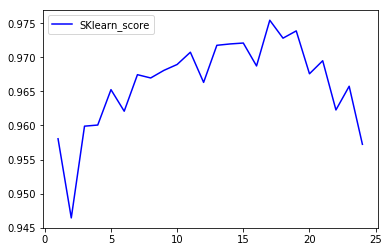

In [134]:
# Задание 3
import matplotlib.pyplot as plt
c = np.zeros([4000, n-1])    # Буду усреднять по 4000 выборкам
n = 25
k = range(1, n)
for j in range(4000):
    iris = datasets.load_iris()
    X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)
    for i in k:
        clf = KNeighborsClassifier(n_neighbors=i)
        clf.fit(X_train, y_train)
        c[j, i-1] = clf.score(X_test, y_test)
    a = c.mean(axis=0)
plt.plot(k, a, color='blue', label='SKlearn_score')
plt.legend()


In [136]:
a.argmax()#соответственно наилучший выбор количества соседей

16

**MNIST**

In [289]:
mnist = fetch_mldata('MNIST original')

In [290]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.1, stratify=mnist.target)

In [291]:
clf = KNeighborsClassifier(n_neighbors=2)
my_clf = MyKNeighborsClassifier(n_neighbors=2)

In [292]:
%time clf.fit(X_train, y_train)

CPU times: user 48.7 s, sys: 168 ms, total: 48.8 s
Wall time: 48.9 s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [293]:
%time my_clf.fit(X_train, y_train)

CPU times: user 53.4 ms, sys: 153 ms, total: 206 ms
Wall time: 1.32 s


In [294]:
%time clf.predict(X_test)

CPU times: user 10min 31s, sys: 604 ms, total: 10min 32s
Wall time: 10min 33s


array([8., 9., 0., ..., 9., 7., 1.])

In [295]:
%time my_clf.predict(X_test)

CPU times: user 1min 37s, sys: 23.8 s, total: 2min 1s
Wall time: 47.9 s


array([8., 9., 0., ..., 9., 7., 1.])

In [296]:
%time clf.predict_proba(X_test)

CPU times: user 10min 37s, sys: 696 ms, total: 10min 38s
Wall time: 10min 38s


array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [297]:
%time my_clf.predict_proba(X_test)

CPU times: user 1min 40s, sys: 21.8 s, total: 2min 1s
Wall time: 43 s


array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [298]:
clf.score(X_test, y_test)

0.9671428571428572

In [299]:
my_clf.score(X_test, y_test)

0.9695714285714285

Задание 5

In [ ]:
# seaborn - библиотека для создания красивых графиков и статистики(основан на матплотлиб )
# matplotlib - библиотека для построения разнообразнейших графиков 
# train_test_split - метод скалерна для разделение датасетов на рандомные поддатасетысеты lk(ghjcnbnt pf )
# Pipeline (from sklearn.pipeline import Pipeline) - инструмент для объединения нескольких 
#трансформаторов вместе с оценкой в один объект. Служит для унификации последовательности обработки данных.
# StandardScaler (from sklearn.preprocessing import StandardScaler) - класс , который нормализует данные(-mean; /std)
# ClassifierMixin - Класс Mixin для всех классификаторов в скалерн, обеспечивает класс предок новыми возможностями
# NeighborsBase -Базовый класс, от которого наследуются классы-классификаторы KNN
# KNeighborsMixin -Класс, расширяет NeighborsBase - добавляет две функции : kneighbors() и  kneighbors_grap()
# SupervisedIntegerMixin - определяет метод fit позволяющий обучить классификатор используя X как тренировочные
# данные и y как целевую переменную.
